# Prototpye 3 Intermediate - Using MEED dataset in a transformer

Use normalised keypoint values in a transformer. Encoding for emotion to video during training is not implemented yet, so none of the videos are trained with the emotions and are trained concat indiscriminantly. Will implement separate videos depending on emotional context after.

!The starting input is currently 1 long list of coords. But be careful because model might learn the transition between 1 video to another which is erroneous

Front videos only.

Adapted from Karpathy's nano-gpt , generator only

In [106]:
# set up environment
import glob
import os 
import numpy as np
import torch
import json
from tqdm import tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


# Set root directory
root_dir = "C:\\Users\\avika\\OneDrive\\Documents\\UAL\\interactive_dance_thesis"
os.chdir(root_dir)

# Check if the current working directory was set correctly
print(os.getcwd())

C:\Users\avika\OneDrive\Documents\UAL\interactive_dance_thesis


## Load and preprocess data

In [107]:
# Load the MEED dataset from folder "multiview-emotional-expressions-dataset"

files = glob.glob("G:/UAL_Thesis/affective_computing_datasets/multiview-emotional-expressions-dataset/*/front_*/processed_data.json")

x_list=[]
y_list=[]
conf_list=[]

# using extend for now but might have to convert to append, assuming all the body parts are always in the correct sequence

for file in tqdm(files):
    with open(file) as f:
        data = json.load(f)
        x_list.extend(data['x'])
        y_list.extend(data['y'])
        conf_list.extend(data['confidence'])
        
len(x_list)

100%|██████████| 1326/1326 [00:10<00:00, 128.80it/s]


3214750

In [141]:
import cv2



max_x, min_x = max(x_list), min(x_list)

max_y, min_y = max(y_list), min(y_list)

    # create 1D array of 50 numbers (x,y,x,y --> 25 keypoints) for each frame
all_frames = []
n_parts = 25

for i in tqdm(range(0, len(x_list), n_parts)):
    frame_data = [coord for pair in zip(x_list[i:i+n_parts], y_list[i:i+n_parts]) for coord in pair]
    all_frames.append(frame_data)

# data has 0s - need to ignore

def visualise_skeleton(all_frames, max_x, max_y, max_frames=100, save=False, save_path=None, prefix=None):
    
    """Input all frames dim 50xn n being the number of frames 50= 25 keypoints x and y coordinates"""

    
    # visualise to check if the data is correct
    # BODY_25 Keypoints
    keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                        'L-Elb', 'L-Wr', 'MidHip', 'R-Hip', 'R-Knee', 'R-Ank', 
                        'L-Hip', 'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 
                        'L-Ear', 'L-BigToe', 'L-SmallToe', 'L-Heel', 'R-BigToe', 
                        'R-SmallToe', 'R-Heel']


    limb_connections = [
        ("Nose", "Neck"),
        ("Neck", "R-Sho"),
        ("R-Sho", "R-Elb"),
        ("R-Elb", "R-Wr"),
        ("Neck", "L-Sho"),
        ("L-Sho", "L-Elb"),
        ("L-Elb", "L-Wr"),
        ("Neck", "MidHip"),
        ("MidHip", "R-Hip"),
        ("R-Hip", "R-Knee"),
        ("R-Knee", "R-Ank"),
        ("MidHip", "L-Hip"),
        ("L-Hip", "L-Knee"),
        ("L-Knee", "L-Ank"),
        ("Nose", "R-Eye"),
        ("R-Eye", "R-Ear"),
        ("Nose", "L-Eye"),
        ("L-Eye", "L-Ear"),
        ("L-Ank", "L-BigToe"),
        ("L-Ank", "L-SmallToe"),
        ("L-Ank", "L-Heel"),
        ("R-Ank", "R-BigToe"),
        ("R-Ank", "R-SmallToe"),
        ("R-Ank", "R-Heel")
    ]

    
    # Initialize a blank canvas (image)
    canvas_size = (int(max_y)+50, int(max_x)+50, 3)  
    canvas = np.zeros(canvas_size, dtype=np.uint8)

    # Define the codec and create VideoWriter object
    if save:
        # Determine the save path
        if save_path is None:
            save_path = "D:\\Interactive Dance Thesis Tests\\TransformerResults"

        # Ensure directory exists
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        # Determine a unique filename
        existing_files = os.listdir(save_path)
        file_num = 1
        while f"{prefix or ''}{file_num}.mp4" in existing_files:
            file_num += 1
        out_path = os.path.join(save_path, f"{prefix or ''}{file_num}.mp4")

        # Create the video writer
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(out_path, fourcc, 10.0, (canvas_size[1], canvas_size[0]))

    # Iterate over every frame
    for frame_data in all_frames[:max_frames]:
        canvas_copy = canvas.copy()

        # Extract x and y coordinates
        x_coords = frame_data[0::2] 
        y_coords = frame_data[1::2]

        # Plot keypoints on the canvas
        for i, (x, y) in enumerate(zip(x_coords, y_coords)):
            x_val = x.item() if torch.is_tensor(x) else x
            y_val = y.item() if torch.is_tensor(y) else y
            cv2.circle(canvas_copy, (int(x_val), int(y_val)), 3, (0, 0, 255), -1)  
            cv2.putText(canvas_copy, keypointsMapping[i], (int(x_val), int(y_val)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

        # Draw connections (limbs) on the canvas
        for limb in limb_connections:
            start_point = (int(x_coords[keypointsMapping.index(limb[0])]), int(y_coords[keypointsMapping.index(limb[0])]))
            end_point = (int(x_coords[keypointsMapping.index(limb[1])]), int(y_coords[keypointsMapping.index(limb[1])]))

            if start_point == (0,0) or end_point == (0,0):
                continue
            cv2.line(canvas_copy, start_point, end_point, (0, 255, 0), 2)  

        # Display the canvas with keypoints and connections
        cv2.imshow("Keypoints Visualization", canvas_copy)

        # If saving, write the frame to the video
        if save:
            out.write(canvas_copy)

        # Wait for 100ms and check for "esc" key press to exit
        key = cv2.waitKey(100)
        if key == 27:  
            break

    # Release the video writer, if used
    if save:
        out.release()

    cv2.destroyAllWindows()


100%|██████████| 128590/128590 [00:00<00:00, 141733.64it/s]


In [109]:
# Normalize the data from -1 to 1 for x and y coordinates (maybe try changing normalization to 0 to 1)? -
# using -1 to 1 with tanh for now because motion likely to be concentrated in centre of frame

max_x, min_x = max(x_list), min(x_list)
normalised_x = [2 * (x_pos - min_x) / (max_x - min_x) - 1 for x_pos in x_list]

max_y, min_y = max(y_list), min(y_list)
normalised_y = [2 * (y_pos - min_y) / (max_y - min_y) - 1 for y_pos in y_list]


normalised_x[:5]

[0.13210917370039654,
 0.16068195263620222,
 0.06514600116364155,
 0.02713045008808801,
 -0.0014977403514718768]

In [110]:

# create 1D array of 50 numbers (x,y,x,y --> 25 keypoints) for each frame
kp_frame = []
n_parts = 25

for i in tqdm(range(0, len(normalised_x), n_parts)):
    frame_data = [coord for pair in zip(normalised_x[i:i+n_parts], normalised_y[i:i+n_parts]) for coord in pair]
    kp_frame.append(frame_data)

len(kp_frame)

100%|██████████| 128590/128590 [00:00<00:00, 168601.91it/s]


128590

In [111]:
data = torch.tensor(kp_frame, dtype= torch.float32)
print(data.shape, data.dtype)
print(data[:5])

torch.Size([128590, 50]) torch.float32
tensor([[ 0.1321, -0.3141,  0.1607, -0.1444,  0.0651, -0.1497,  0.0271,  0.0473,
         -0.0015,  0.2224,  0.2609, -0.1441,  0.2846,  0.0583,  0.3035,  0.2497,
          0.1556,  0.2225,  0.0843,  0.2224,  0.0795,  0.5509,  0.0651,  0.8628,
          0.2180,  0.2225,  0.2463,  0.5562,  0.2752,  0.8571,  0.1129, -0.3306,
          0.1604, -0.3414,  0.0891, -0.3030,  0.2033, -0.3195,  0.3035,  0.9338,
          0.3228,  0.9119,  0.2654,  0.8736,  0.0603,  0.9448,  0.0317,  0.9340,
          0.0747,  0.8791],
        [ 0.1367, -0.3140,  0.1653, -0.1444,  0.0699, -0.1497,  0.0318,  0.0527,
          0.0032,  0.2280,  0.2656, -0.1390,  0.2847,  0.0638,  0.3082,  0.2662,
          0.1557,  0.2224,  0.0844,  0.2223,  0.0796,  0.5562,  0.0651,  0.8629,
          0.2226,  0.2225,  0.2465,  0.5562,  0.2752,  0.8572,  0.1175, -0.3305,
          0.1606, -0.3412,  0.0938, -0.3031,  0.2037, -0.3194,  0.3035,  0.9338,
          0.3228,  0.9120,  0.2608,  0.873

In [112]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [113]:
block_size = 8
train_data[:block_size+1]

tensor([[ 0.1321, -0.3141,  0.1607, -0.1444,  0.0651, -0.1497,  0.0271,  0.0473,
         -0.0015,  0.2224,  0.2609, -0.1441,  0.2846,  0.0583,  0.3035,  0.2497,
          0.1556,  0.2225,  0.0843,  0.2224,  0.0795,  0.5509,  0.0651,  0.8628,
          0.2180,  0.2225,  0.2463,  0.5562,  0.2752,  0.8571,  0.1129, -0.3306,
          0.1604, -0.3414,  0.0891, -0.3030,  0.2033, -0.3195,  0.3035,  0.9338,
          0.3228,  0.9119,  0.2654,  0.8736,  0.0603,  0.9448,  0.0317,  0.9340,
          0.0747,  0.8791],
        [ 0.1367, -0.3140,  0.1653, -0.1444,  0.0699, -0.1497,  0.0318,  0.0527,
          0.0032,  0.2280,  0.2656, -0.1390,  0.2847,  0.0638,  0.3082,  0.2662,
          0.1557,  0.2224,  0.0844,  0.2223,  0.0796,  0.5562,  0.0651,  0.8629,
          0.2226,  0.2225,  0.2465,  0.5562,  0.2752,  0.8572,  0.1175, -0.3305,
          0.1606, -0.3412,  0.0938, -0.3031,  0.2037, -0.3194,  0.3035,  0.9338,
          0.3228,  0.9120,  0.2608,  0.8738,  0.0558,  0.9449,  0.0271,  0.9339,


In [114]:
np.shape(train_data)

torch.Size([115731, 50])

In [115]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel? - every forward and backward pass in transformer
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    data = train_data if split == 'train' else val_data

    # We need to account for the fact that our data is 2-dimensional when creating batches.
    ix = torch.randint(len(data) - block_size, (batch_size,))
    
    # Adjusted these lines to consider the 50-dimensional poses
    x = torch.stack([data[i:i+block_size, :] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1, :] for i in ix])
    
    x, y = x.to(device), y.to(device)
    return x, y


xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

# each 4x8 array contains 32 examples of context-target pairs which is completely independent of each other to the transformer
for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

# x will be the input, and transformer will look at all examples and look at the target y 

inputs:
torch.Size([4, 8, 50])
tensor([[[ 0.0412, -0.3962,  0.0413,  ...,  0.8024,  0.0699,  0.7478],
         [ 0.0176, -0.3960,  0.0461,  ...,  0.7972,  0.0698,  0.7478],
         [ 0.0081, -0.3960,  0.0508,  ...,  0.7970,  0.0653,  0.7425],
         ...,
         [ 0.0129, -0.3960,  0.0653,  ...,  0.7971,  0.0653,  0.7370],
         [ 0.0177, -0.4015,  0.0794,  ...,  0.7918,  0.0651,  0.7368],
         [ 0.0317, -0.4017,  0.0844,  ...,  0.7970,  0.0699,  0.7424]],

        [[ 0.0463, -0.3357,  0.0224,  ...,  0.8955,  0.0460,  0.8410],
         [ 0.0460, -0.3413,  0.0223,  ...,  0.8956,  0.0461,  0.8517],
         [ 0.0367, -0.3415,  0.0222,  ...,  0.8955,  0.0462,  0.8517],
         ...,
         [ 0.0413, -0.3632,  0.0413,  ...,  0.8683,  0.0079,  0.8245],
         [ 0.0412, -0.3632,  0.0414,  ...,  0.8736,  0.0126,  0.8245],
         [ 0.0412, -0.3632,  0.0414,  ...,  0.8684,  0.0126,  0.8245]],

        [[ 0.0605, -0.3467,  0.0606,  ...,  0.7641,  0.0222,  0.6988],
         [ 0.0

In [ ]:
# class LayerNorm1d: # (used to be BatchNorm1d) - Layer normalisation in pytorch - overcome optimisation issue for deep nn
#   # running buffers not maintained
#   # apply before SA blocks - different from original transformer paper   - prenorm transformation
#   # Currenly not used and using nn.LayerNorm(n_emb , device=device)

#   def __init__(self, dim, eps=1e-5, momentum=0.1):
#     self.eps = eps
#     self.gamma = torch.ones(dim,device=device)
#     self.beta = torch.zeros(dim,device=device)

#   def __call__(self, x):
#     # calculate the forward pass
#     xmean = x.mean(1, keepdim=True) # batch mean  - normalise rows not columns (dim = 1)
#     xvar = x.var(1, keepdim=True) # batch variance - normalise rows not columns (dim = 1)
#     xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
#     self.out = self.gamma * xhat + self.beta
#     return self.out

#   def parameters(self):
#     return [self.gamma, self.beta]
        

In [242]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math

torch.manual_seed(1337)

# let's start with a very simple model

def positional_encoding(seq_len, d_model):
    """
    Returns the positional encoding for a given sequence length and model size.

    Parameters:
    - seq_len (int): Length of the sequence.
    - d_model (int): Size of the model embedding.

    Returns:
    - A tensor of shape (seq_len, d_model) containing the positional encoding.
    """
    
    position = torch.arange(seq_len).unsqueeze(1).float() # [seq_len, 1]
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                         (-math.log(10000.0) / d_model))  # [d_model/2]
    pos_enc = torch.zeros((seq_len, d_model))

    pos_enc[:, 0::2] = torch.sin(position * div_term) # apply sin to even indices in the array; 2i
    pos_enc[:, 1::2] = torch.cos(position * div_term) # apply cos to odd indices in the array; 2i+1

    return pos_enc


class Head(nn.Module):
    """one head of self attention"""
    
    def __init__(self,head_size,n_emb):
        super().__init__()
        self.key = nn.Linear(n_emb, head_size, bias=False, device=device)
        self.query = nn.Linear(n_emb, head_size, bias=False, device=device)
        self.value = nn.Linear(n_emb, head_size, bias=False, device=device)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.n_emb = n_emb
    
    def forward(self, x):
        B,T,C = x.shape # batch size, time, context
        # key, query, value
        k = self.key(x) # B,T,C
        q = self.query(x) # B,T,C
        v= self.value(x) # B,T,C
        
        # compute attention scores ("affinities")
         # Scaled dot-product attention - same as below
        # attention = torch.einsum("nqhd,nkhd->nhqk", [queries, keys]) / math.sqrt(self.embed_size)

        wei = q @ k.transpose(-1,-2) # B,T,T
        wei /= math.sqrt(self.n_emb) # scale by sqrt of embedding dimension
        self.tril = self.tril.to(device)
        wei = wei.masked_fill(self.tril[:T,:T] == 0, float('-inf')) # mask out upper triangular part so don't attend to future
        wei = F.softmax(wei, dim=-1) # B,T,T
        
        # apply attention to values - weighted aggregation
        out = wei @ v # (B,T,T) @ (B,T,C) --> B,T,C
        
        return out
        
        
class MultiHeadAttention(nn.Module):
    
    def __init__(self,num_heads,head_size,n_emb):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size,n_emb) for _ in range(num_heads)])
        self.proj = nn.Linear(n_emb, n_emb, bias=False, device=device) # (B,T,C) - projection back into residual pathway
        
    def forward(self, x):
        # x is (B,T,C)
        out = torch.cat([h(x) for h in self.heads], dim=-1) # (B,T,C*num_heads)
        out = self.proj(out) # (B,T,C) - projection back into residual pathway
        return out
    
class FeedForward(nn.Module):
    """A simple lineear layer followed by a ReLU - allows all tokens to think on data individually"""
    
    def __init__(self,n_emb):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_emb, 4 * n_emb , device=device), # 4 * because recommended in paper residual pathway - growing residual pathway
            nn.ReLU(),
            nn.Linear( 4* n_emb, n_emb , device=device), # required otherwise output will collapse  - projection back into residual pathway
          
        )
    
    def forward(self, x):
        return self.net(x)
    

class Block(nn.Module):
    """Transformer Block: communication followed by computation - basically self attention heads and feedforward"""

    def __init__(self, n_emb, n_heads):
        
        super().__init__()
        head_size = n_emb//n_heads
        self.sa = MultiHeadAttention(num_heads=n_heads, head_size=head_size, n_emb=n_emb)
        self.ffwd = FeedForward(n_emb=n_emb)
        self.ln1 =  nn.LayerNorm(n_emb , device=device)
        self.ln2 =  nn.LayerNorm(n_emb, device=device)
        
    def forward(self, x):
        # x + due to residual connection
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x
    
class MotionModel(nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden_dim=32, n_layers=4):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias=False, device=device) 
        self.fc2 = nn.Linear(hidden_dim, output_dim, bias=False,device=device)
        # PROBLEM
        self.positional_encoding = positional_encoding(seq_len=block_size, d_model=hidden_dim).to(device)
        self.blocks = nn.Sequential(*[Block(n_emb=hidden_dim, n_heads=4) for _ in range(n_layers)])
        self.lm_head = nn.Linear(hidden_dim, hidden_dim, bias=False, device=device)
       
    
        
    def forward(self, inputs, targets=None):
        B,T,C = inputs.shape # batch size, time, context
        
        # fc1 transforms input into hidden dimension
        x = self.fc1(inputs) # B,T,hidden dimension
        # Add positional encoding
       
        x += positional_encoding(seq_len=T, d_model=self.hidden_dim).to(device) # positional_encoding = T,hidden dimension , added = B,T,hidden dimension
        
        x = self.blocks(x) # B,T,hidden dimension
        x = self.lm_head(x) # B,T,hidden dimension
        
        # fc2 transforms hidden dimension into output dimension
        logits = self.fc2(x)
        
        
        if targets is None:
            loss = None
        
        else:
            B,T,C = inputs.shape # batch size, time, context
            loss = F.mse_loss(logits, targets) # mse picked cause continous data
        
        return logits,loss
    
    def generate(self,inputs,max_new_tokens):
        # inputs is (B,T) array of indices in current context
        # get current prediction
    
        generated_sequence = inputs
        
        for _ in range(max_new_tokens):
            cond_sequence = generated_sequence[:, -block_size:] # get the last block_size tokens from the generated sequence so positional doesn't run out
            # don't actually need to do this cause positional is sinusoidal but just in case since model trained with blocksize
            logits, _ = self(cond_sequence)
            next_values = logits[:, -1, :]  # Get the values from the last timestep
            
            # Append the predicted values to the sequence
            generated_sequence = torch.cat([generated_sequence, next_values.unsqueeze(1)], dim=1)
        
        return generated_sequence

    
m = MotionModel(input_dim=50, output_dim=50)
out,loss = m(xb, yb)
print(out.shape)
print(out)
# loss interpreted on scale of data
print(f"loss: {loss}")


            
    

torch.Size([4, 8, 50])
tensor([[[-0.1591, -0.1697,  0.8745,  ...,  0.1430, -0.4912, -0.3977],
         [-0.0996,  0.0266,  0.9787,  ...,  0.1672, -0.4669, -0.4352],
         [ 0.0378,  0.3510,  1.0575,  ...,  0.1736, -0.5237, -0.4067],
         ...,
         [-0.2950, -0.1413,  0.6464,  ...,  0.3201, -0.0412, -0.1926],
         [-0.2775, -0.2168,  0.7598,  ...,  0.1892, -0.1027, -0.1472],
         [-0.2532, -0.1424,  0.9129,  ...,  0.0893, -0.1333, -0.1775]],

        [[-0.1645, -0.1992,  0.9078,  ...,  0.1612, -0.4954, -0.4141],
         [-0.1050, -0.0134,  1.0256,  ...,  0.1813, -0.4693, -0.4559],
         [-0.1124,  0.1041,  0.9753,  ...,  0.2783, -0.3590, -0.4808],
         ...,
         [-0.3206, -0.1794,  0.7186,  ...,  0.3321, -0.0388, -0.2099],
         [-0.2915, -0.2748,  0.8513,  ...,  0.1516, -0.0905, -0.2132],
         [-0.2602, -0.2102,  0.9831,  ...,  0.0503, -0.1233, -0.2705]],

        [[-0.1852, -0.1506,  0.9737,  ...,  0.1113, -0.4834, -0.4581],
         [-0.1355,  0.

In [243]:
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)

  0%|          | 8/20000 [00:02<1:05:33,  5.08it/s] 

train loss: 0.263821 val loss: 0.255415


  5%|▌         | 1007/20000 [00:19<26:46, 11.82it/s]

train loss: 0.005131 val loss: 0.005612


 10%|█         | 2010/20000 [00:37<28:04, 10.68it/s]

train loss: 0.004449 val loss: 0.004216


 15%|█▌        | 3008/20000 [00:56<25:58, 10.90it/s]

train loss: 0.003637 val loss: 0.003957


 20%|██        | 4008/20000 [01:15<20:33, 12.96it/s]

train loss: 0.004329 val loss: 0.003699


 25%|██▌       | 5013/20000 [01:33<15:42, 15.91it/s]

train loss: 0.003847 val loss: 0.003585


 30%|███       | 6015/20000 [01:51<13:34, 17.17it/s]

train loss: 0.004312 val loss: 0.003390


 35%|███▌      | 7007/20000 [02:09<17:55, 12.08it/s]

train loss: 0.004317 val loss: 0.004493


 40%|████      | 8008/20000 [02:27<15:33, 12.85it/s]

train loss: 0.003850 val loss: 0.003668


 45%|████▌     | 9015/20000 [02:45<10:29, 17.45it/s]

train loss: 0.003642 val loss: 0.004536


 50%|█████     | 10012/20000 [03:01<11:21, 14.66it/s]

train loss: 0.003696 val loss: 0.003648


 55%|█████▌    | 11011/20000 [03:17<09:36, 15.59it/s]

train loss: 0.003899 val loss: 0.003809


 60%|██████    | 12007/20000 [03:33<09:25, 14.12it/s]

train loss: 0.003844 val loss: 0.003039


 65%|██████▌   | 13009/20000 [03:51<09:14, 12.61it/s]

train loss: 0.003978 val loss: 0.003723


 70%|███████   | 14007/20000 [04:09<09:16, 10.77it/s]

train loss: 0.003817 val loss: 0.003462


 75%|███████▌  | 15009/20000 [04:27<05:39, 14.71it/s]

train loss: 0.004032 val loss: 0.003533


 80%|████████  | 16014/20000 [04:44<05:10, 12.82it/s]

train loss: 0.004327 val loss: 0.003362


 85%|████████▌ | 17014/20000 [05:01<03:43, 13.35it/s]

train loss: 0.003940 val loss: 0.003218


 90%|█████████ | 18009/20000 [05:17<02:25, 13.68it/s]

train loss: 0.004370 val loss: 0.003765


 95%|█████████▌| 19013/20000 [05:34<01:07, 14.67it/s]

train loss: 0.004512 val loss: 0.003157


100%|██████████| 20000/20000 [05:47<00:00, 57.50it/s]


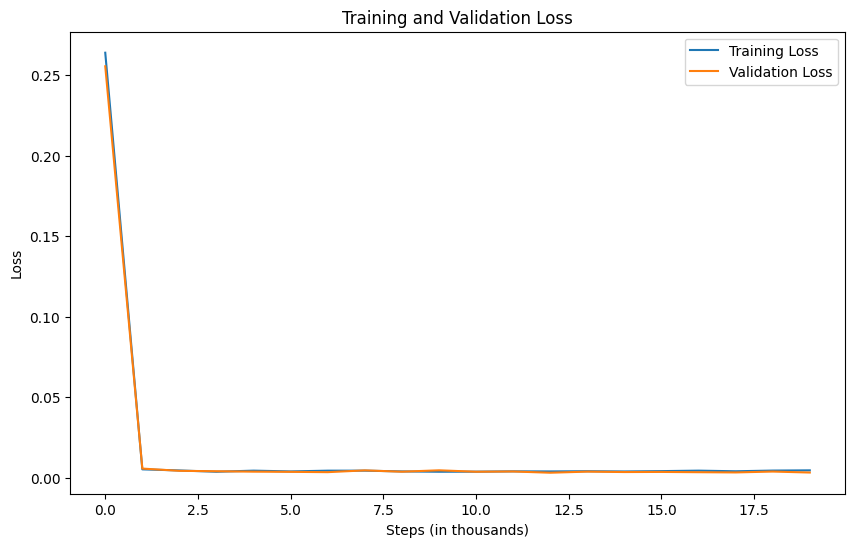

In [237]:
# training loop

import matplotlib.pyplot as plt

@torch.no_grad()
def estimate_loss():
    out = {}
    m.eval()
    eval_iters = 200
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            xb, yb = get_batch(split)
            logits, loss = m(xb, yb)
            losses[k] = loss.item()
        out[split] = losses.mean()
    m.train()
    return out


batch_size = 4
train_losses = []
val_losses = []
for steps in tqdm(range(20000)):
    # get sample batch of data
    xb,yb = get_batch('train')
    # evaluate loss
    logits, loss = m(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
    if steps % 1000 == 0:
        losses = estimate_loss()
        print(f"train loss: {losses['train']:.6f} val loss: {losses['val']:.6f}")
        
         # Store the losses for plotting
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])
        
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10,6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Steps (in thousands)')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

# After the training loop, plot the losses
plot_losses(train_losses, val_losses)

In [238]:
# generate new sequence

generated = m.generate(xb, 50)
print(generated.shape)

torch.Size([4, 58, 50])


In [239]:
def unnormalise_list(data_list, max_x, min_x, max_y, min_y):
    unnormalized_data = []
    for i in range(0, len(data_list), 2):  # Step by 2 to get x, y pairs
        x = data_list[i]
        y = data_list[i+1]
        
        # Unnormalize x and y
        unnormalized_x = (x+1)/2 * (max_x-min_x) + min_x
        unnormalized_y = (y+1)/2 * (max_y-min_y) + min_y
        
        # Append to result list
        unnormalized_data.extend([unnormalized_x, unnormalized_y])
    
    return unnormalized_data




unnorm_out = unnormalise_list(generated, max_x, min_x, max_y, min_y)

# visualise and save
for batch in unnorm_out:
    visualise_skeleton(batch, max_x, max_y, max_frames=100,save = True,save_path=None,prefix='adam_20000steps_blockswresidual')

In [122]:
out.shape

torch.Size([4, 8, 50])

In [ ]:
# # continuous GPT


# import torch
# import torch.nn as nn
# from torch.nn import functional as F
# import math

# torch.manual_seed(1337)


# # this is set to eval mode because we don't want to train the model, we just want to estimate the loss, for this model the modes won't be different
# # but for other models, the modes will be different depending on what layers are present
# # torch.no_grad() - we don't want to calculate gradients because we don't want to train the model, we will not call backward, better memory management
# @torch.no_grad()
# def estimate_loss():
#     out = {}
#     model.eval()
#     eval_iters = 200
#     for split in ['train', 'val']:
#         losses = torch.zeros(eval_iters)
#         for k in range(eval_iters):
#             xb, yb = get_batch(split)
#             logits, loss = model(xb, yb)
#             losses[k] = loss.item()
#         out[split] = losses.mean()
#     model.train()
#     return out

# def positional_encoding(seq_len, d_model):
#     """
#     Returns the positional encoding for a given sequence length and model size.

#     Parameters:
#     - seq_len (int): Length of the sequence.
#     - d_model (int): Size of the model embedding.

#     Returns:
#     - A tensor of shape (seq_len, d_model) containing the positional encoding.
#     """
    
#     position = torch.arange(seq_len).unsqueeze(1).float() # [seq_len, 1]
#     div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
#                          (-math.log(10000.0) / d_model))  # [d_model/2]
#     pos_enc = torch.zeros((seq_len, d_model))

#     pos_enc[:, 0::2] = torch.sin(position * div_term) # apply sin to even indices in the array; 2i
#     pos_enc[:, 1::2] = torch.cos(position * div_term) # apply cos to odd indices in the array; 2i+1

#     return pos_enc



# class MotionModel(nn.Module):

#     def __init__(self, input_dim, hidden_dim, num_heads, num_layers):
#         super().__init__()

#         # Initial transformation layer
#         self.fc1 = nn.Linear(input_dim, hidden_dim)
        
#         # Transformer layers
#         encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads)
#         self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

#         # Positional encoding
#         self.positional_encoding = positional_encoding(seq_len=block_size, d_model=hidden_dim).to(device)

#         # Output layer
#         self.fc2 = nn.Linear(hidden_dim, input_dim)

#     def forward(self, pose_sequence,targets=None):
#         # Feature transformation
#         x = self.fc1(pose_sequence)

#         # Add positional encoding
#         seq_len = x.shape[1]
#         x += self.positional_encoding[:seq_len, :]


#         # Transformer layers
#         x = self.transformer(x)

#         # Predicting the next pose
#         logits = self.fc2(x)
        
        
#         if targets is None:
#             loss = None
#         else:
#             B, T, C = logits.shape
#             # pytorch wants (B*T,C) so we have to transpose because it wants C in the 2nd dimension
#             logits = logits.view(B*T, C)
#             # look at prediction
#             targets = targets.view(B*T, -1)

#             # evaluate loss
#             # negative log likelihood loss a.k. cross entropy loss
#             # we have the identity of the next character so how well are we predicting the next character based on the logits
#             # ideally the correct logits should be 1 and the rest should be 0, but in reality this is not the case
            
#             loss = F.cross_entropy(logits, targets)

#         return logits,loss

#     def training_step(self, pose_sequence, next_pose):
#         predicted_pose = self(pose_sequence)
#         loss = nn.MSELoss()(predicted_pose, next_pose)
#         return loss
    
#     def generate(self, initial_pose_sequence, max_new_poses):
#         """
#         Generate a sequence of poses.

#         Parameters:
#         - initial_pose_sequence: Starting sequence of poses.
#         - max_new_poses: Maximum number of new poses to generate.

#         Returns:
#         - Generated sequence of poses.
#         """

#         generated_sequence = initial_pose_sequence

#         for _ in range(max_new_poses):
#             # Get the predicted next pose
#             logits, _ = self(generated_sequence)
#             next_pose = logits


#             # Append the predicted pose to the sequence
#             generated_sequence = torch.cat([initial_pose_sequence,next_pose],dim=1)  # Add sequence dimension


#         return generated_sequence



# model = MotionModel(input_dim=50, hidden_dim=128, num_heads=4, num_layers=4)
# m = model.to(device)
# logits, loss = m(xb, yb)
# print(logits.shape)
# print(loss)
# output= m.generate(initial_pose_sequence=xb[0], max_new_poses=100)[0].tolist()
# print(np.shape(output))



In [ ]:
np.shape(xb)

In [ ]:
# # Preprocess the MEED dataset for transformer
# # 1D array of 50 (25 keypoints x,y ) = 1 frame = 1 token
# # block size of 10 so input is 10x50 dims

# from torch.utils.data import DataLoader, TensorDataset, random_split

# # Example: load your keypoints from a file, preprocess, and convert them into PyTorch tensors
# # keypoints = ...
# # For the sake of this example, let's assume keypoints is a torch.Tensor of shape [num_samples, sequence_len, 50]

# # Create data loaders
# batch_size = 32
# train_loader = DataLoader(xb, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(yb, batch_size=batch_size, shuffle=False)


In [ ]:
# Hyperparameters
learning_rate = 1e-3
epochs = 10

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    for batch in train_loader:
        optimizer.zero_grad()
        
        # Assuming each batch is a sequence of poses
    
        
        outputs = model(xb)
        loss = model.training_step(outputs, yb)
        
        loss.backward()
        optimizer.step()

    # Print loss (or evaluate on validation set)
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


In [ ]:
np.shape(batch[:, block_size,:])

In [ ]:
np.shape(inputs)

In [ ]:
np.shape(batch)

In [ ]:
# transformer


In [ ]:
# visualise results